### data set
https://www.kaggle.com/retailrocket/ecommerce-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### идеи
todo:
- разбить по дням недели и времени суток
- анализировать покупки и добавление в корзину и просмотры - исходя из наличия, категории и близости обьектов (+ обьектов потребляемых совместно с текущим объектом)

### load data

In [3]:
category_tree = pd.DataFrame.from_csv('./data/category_tree.csv')

In [6]:
category_tree.parentid = category_tree.parentid.astype('int')

In [5]:
category_tree.parentid = category_tree.parentid.fillna(-1)

In [7]:
events = pd.DataFrame.from_csv('./data/events.csv')

In [4]:
events.reset_index(inplace=True)

In [8]:
item_properties =  pd.DataFrame.from_csv('./data/item_properties_part1.csv').append(pd.DataFrame.from_csv('./data/item_properties_part2.csv')) 

In [9]:
events.reset_index(inplace=True)

In [10]:
#заменяем NaN на -1 - и приводим к int-у

In [11]:
events.transactionid = events.transactionid.fillna(-1)

In [12]:
events.transactionid = events.transactionid.astype('int')

In [13]:
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,-1
1,1433224214164,992329,view,248676,-1
2,1433221999827,111016,view,318965,-1
3,1433221955914,483717,view,253185,-1
4,1433221337106,951259,view,367447,-1


In [14]:
item_properties.reset_index(inplace=True)

In [15]:
item_properties.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


### events explore

In [423]:
events.shape

(1754431, 5)

In [16]:
#количество уникальных пользователей
events.visitorid.unique().size

1407580

In [17]:
#количество типов событий
events.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

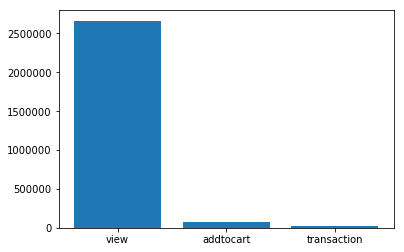

In [18]:
plt.bar(np.arange(events.event.value_counts().shape[0]), events.event.value_counts().values)
plt.xticks(np.arange(events.event.value_counts().shape[0]), events.event.value_counts().index)
plt.show()

#### transaction analys

In [19]:
tran = pd.DataFrame(events.transactionid.value_counts().values, events.transactionid.value_counts().index, columns=['count'])
tran = tran.loc[(tran['count'] > 1)&(tran.index != -1)]
#кол-во покупок с разными позициями
tran.index.shape

(2710,)

In [20]:
tran.head()

,count
7063,31
765,28
8351,27
2753,23
6993,21


In [21]:
#проверим есть ли покупки с одной id транзакции от разных пользоваетелей

In [22]:
frod = events.loc[events.transactionid.isin(tran.index) ]

In [23]:
frod.shape

(7495, 5)

In [24]:
frod = frod.sort_values(['visitorid', 'timestamp'], ascending=[True, True])

In [25]:
%%time
frod_ =  frod[['timestamp','visitorid','itemid','transactionid']].groupby('transactionid').agg(['min','max','count','nunique'])

CPU times: user 10.5 ms, sys: 1.28 ms, total: 11.7 ms
Wall time: 10.7 ms


In [26]:
#таких нет
frod_.loc[frod_['visitorid']['nunique']>1].shape

(0, 12)

In [27]:
frod_['len'] = (frod_['timestamp']['max'] - frod_['timestamp']['min'])/(1000)

In [28]:
#за то есть транзакции время которых больше 1 минуты , а также дублированные записи...

In [29]:
frod_ =frod_.sort_values('len', ascending=False)
frod_.loc[frod_['len'] > 60].shape

(44, 13)

In [30]:
#таких outlayer-ов не много. эти ссесиий можно будет при необходимости выбросить

### timestamps analys

In [31]:
#сделаем агрегированый сет по timestamp 
#вычислим время для visitorid

In [32]:
%%time
timestamps =  events[['timestamp','visitorid']].groupby('visitorid').agg(['max','min','count','nunique'])

CPU times: user 1.18 s, sys: 161 ms, total: 1.34 s
Wall time: 1.34 s


In [33]:
timestamps['len,min'] = (timestamps['timestamp']['max'] - timestamps['timestamp']['min'])/(1000*60)

In [34]:
timestamps.head()

timestamp                                 len,min
                     max            min count nunique           
visitorid                                                       
0          1442004917175  1442004589439     3       3   5.462267
1          1439487966444  1439487966444     1       1   0.000000
2          1438971657845  1438969904567     8       8  29.221300
3          1438413035296  1438413035296     1       1   0.000000
4          1442352267167  1442352267167     1       1   0.000000

In [35]:
# min, max, mean, median - кольчества событий приходящиеся на пользователя
print(timestamps['timestamp']['count'].min(),timestamps['timestamp']['count'].max(), timestamps['timestamp']['count'].mean(),timestamps['timestamp']['count'].median())

1 7757 1.9580421716705267 1.0


In [36]:
#у большинства пользователей мало событий - [их нужно будет отфильтровать тк они врядли несут полезную информацию]
print("Кол-во пользователей:",timestamps.shape[0])
print("Кол-во 1-ых сессий:",timestamps.loc[timestamps['timestamp']['count'] == 1].shape[0])
print("\nКол-во не 1-ых сессий :",timestamps.loc[timestamps['timestamp']['count'] > 1].shape[0])

Кол-во пользователей: 1407580
Кол-во 1-ых сессий: 1001560

Кол-во не 1-ых сессий : 406020


In [37]:
# min, max, mean, median - длинны "сессии" на пользователя  в минутах
print(timestamps['len,min'].min(),timestamps['len,min'].max(), timestamps['len,min'].mean(),timestamps['len,min'].median())

0.0 198680.91575 3420.7057509405886 0.0


In [38]:
#у большинства пользователей короткие сессии - [их тоже нужно будет отфильтровать]
print("Кол-во пользователей:",timestamps.shape[0])
print("Кол-во  сессий 0-ой длительности:",timestamps.loc[timestamps['len,min'] == 0].shape[0])
print("\nКол-во не 0-ой длительности :",timestamps.loc[timestamps['len,min'] > 0].shape[0])

Кол-во пользователей: 1407580
Кол-во  сессий 0-ой длительности: 1001614

Кол-во не 0-ой длительности : 405966


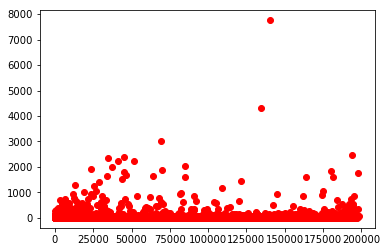

In [39]:
plt.plot( timestamps['len,min'].values, timestamps['timestamp']['count'].values, 'ro')

plt.show()

In [40]:
t = timestamps.loc[ (timestamps['timestamp']['count']> 1) & (timestamps['len,min'] > 0)]
print(t['timestamp']['count'].min(), t['timestamp']['count'].max(), t['timestamp']['count'].mean(),t['timestamp']['count'].median())
print(t['len,min'].min(), t['len,min'].max(),t['len,min'].mean(),t['len,min'].median())

2 7757 4.321620529798062 2.0
1.66666666667e-05 198680.91575 11860.394715096716 16.701016666666668


In [41]:
#мы выбросили вот столько пользователей
events.visitorid.unique().size - t.index.size

1001614

In [42]:
#режем :)

In [43]:
events = events.loc[ events.visitorid.isin(t.index)]

In [44]:
events.shape

(1754431, 5)

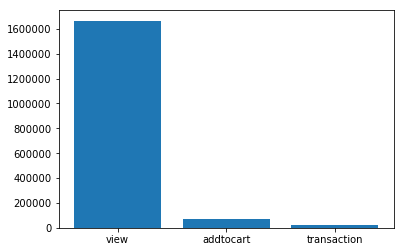

In [45]:
plt.bar(np.arange(events.event.value_counts().shape[0]), events.event.value_counts().values)
plt.xticks(np.arange(events.event.value_counts().shape[0]), events.event.value_counts().index)
plt.show()

In [46]:
##анализ интервалов между событиями пользователя

In [47]:
e = events.sort_values(['visitorid', 'timestamp'], ascending=[True, True])

In [48]:
e = e.reset_index(drop=True)

In [49]:
e['delta'] = 0

In [50]:
e.head()

,timestamp,visitorid,event,itemid,transactionid,delta
0,1442004589439,0,view,285930,-1,0
1,1442004759591,0,view,357564,-1,0
2,1442004917175,0,view,67045,-1,0
3,1438969904567,2,view,325215,-1,0
4,1438970013790,2,view,325215,-1,0


In [51]:
%%time
a = np.zeros(e.shape[0])
user = 0
delta = e.timestamp.iloc[0]
for index, row in e.iterrows():
    if user != row['visitorid']:
        delta = row['timestamp']
    
    a[index] = np.round((row['timestamp'] - delta)/(1000*60),0)
    delta = row['timestamp'] 
    user = row['visitorid']
    #print(index)

CPU times: user 3min 2s, sys: 554 ms, total: 3min 3s
Wall time: 3min 4s


In [52]:
a_  = pd.DataFrame(a, columns= ['delta'])


In [53]:
print(a_['delta'].mean(),a_['delta'].median())

2744.4167117430097 1.0


In [54]:
#больше суток точно разные сессии

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1181db7f0>]], dtype=object)

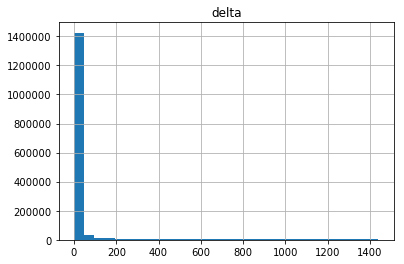

In [55]:
a_.loc[(a_.delta < 1441)].hist(bins=30)

In [56]:
print(a_.loc[(a_.delta < 1441)]['delta'].mean(),a_.loc[(a_.delta < 1441)]['delta'].median())

48.695235783833155 1.0


In [57]:
print(a_.loc[(a_.delta < 1441)&(a_.delta > 0)]['delta'].mean(),a_.loc[(a_.delta < 1441)&(a_.delta > 0.1)]['delta'].median())

86.45631420254752 3.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c8e7710>]], dtype=object)

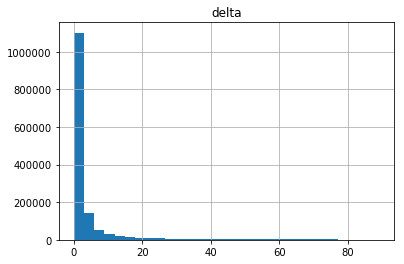

In [58]:
a_.loc[(a_.delta < 90)].hist(bins=30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118449748>]], dtype=object)

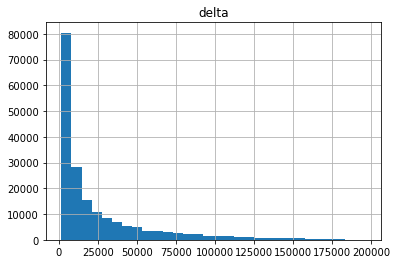

In [59]:
a_.loc[(a_.delta > 1440)].hist(bins=30)

In [60]:
a_.shape[0]

1754431

In [61]:
#событий с разницей > 24часов
# умножаем на 2 тк 1 - сесия равна 0
print(a_.loc[(a_.delta > 1440)].shape[0]*2)

377392


In [62]:
m = a_.loc[(a_.delta > 0)]['delta'].median()
#событий с разницей > медианного значения
print(a_.loc[(a_.delta > m)].shape[0]*2)

1018904


In [63]:
m = a_.loc[(a_.delta > 0)&(a_.delta < 1441)]['delta'].mean()
#событий с разницей > среднего значения(среднее по сессиям < 24 часов)
print(a_.loc[(a_.delta > m)].shape[0]*2)

607402


In [64]:
#разобьем дата сет на сессии

In [65]:
#можно одновременно считать дельту дульту с разбивкий  и id сессии

In [66]:
e.delta = a_

In [67]:
%%time
#нужно переписать
d = np.zeros(e.shape[0])
d1 = np.zeros(e.shape[0])
s = np.chararray(e.shape[0],itemsize=20)
user = 0
ssid = '0'
delta = e.timestamp.iloc[0]
inc = 0
for index, row in e.iterrows():
    if user != row['visitorid']:
        delta = row['timestamp']
        ssid = str(row['visitorid'])
        inc = 0 
    
    d[index] = np.round((row['timestamp'] - delta)/(1000*60),3)

    if (d[index]/90) > 1:
        d1[index] = 0
        inc += 1
        ssid =  str(row['visitorid']) +'_'+str(inc)
    else:
        #print(d[index] , index) 
        d1[index] = d[index]

    
    s[index] = ssid
    delta = row['timestamp'] 
    user = row['visitorid']
    #print( s[index])
    #print(index)

CPU times: user 3min 32s, sys: 738 ms, total: 3min 32s
Wall time: 3min 33s


In [68]:
e['delta1'] = d1
e['ssid'] = s
#e = e.drop(['session_id'], axis = 1)

In [69]:
e.tail()

,timestamp,visitorid,event,itemid,transactionid,delta,delta1,ssid
1754426,1437973995037,1407573,view,57720,-1,4.0,3.725,b'1407573_1'
1754427,1438402327230,1407573,view,363109,-1,7139.0,0.000,b'1407573_2'
1754428,1438402365311,1407573,view,463766,-1,1.0,0.635,b'1407573_2'
1754429,1438648367715,1407573,view,82278,-1,4100.0,0.000,b'1407573_3'
1754430,1438648495146,1407573,view,82278,-1,2.0,2.124,b'1407573_3'


In [ ]:
##посмотрим сколько у которых больше 1-ой сессии

In [518]:
%%time
convertion =  e[['ssid','visitorid']].groupby('visitorid').agg(['count','nunique'])

CPU times: user 326 ms, sys: 83.1 ms, total: 409 ms
Wall time: 411 ms


In [533]:
convertion.loc[convertion['ssid']['nunique']>1].shape

(163079, 2)

In [535]:
convertion.loc[convertion['ssid']['nunique']>10].shape

(2285, 2)

In [70]:
## повторим предыдущий анализ

In [441]:
%%time
timestamps =  e[['timestamp','ssid','delta1']].groupby('ssid').agg(['mean','median','max','min','count','nunique'])

CPU times: user 1.99 s, sys: 244 ms, total: 2.23 s
Wall time: 2.27 s


In [442]:
timestamps['len,min'] = (timestamps['timestamp']['max'] - timestamps['timestamp']['min'])/(1000*60)

In [443]:
timestamps.head()

timestamp                                                    \
                      mean        median            max            min count   
ssid                                                                           
b'0'          1.442005e+12  1.442005e+12  1442004917175  1442004589439     3   
b'100'        1.441756e+12  1.441756e+12  1441756374884  1441756135990     4   
b'10000'      1.435889e+12  1.435889e+12  1435889141392  1435888834563     6   
b'1000001'    1.436293e+12  1.436293e+12  1436292734953  1436292734953     1   
b'1000001_1'  1.437770e+12  1.437770e+12  1437770157029  1437769095303     3   

                        delta1                                       len,min  
             nunique      mean  median     max  min count nunique             
ssid                                                                          
b'0'               3  1.820667  2.6260   2.836  0.0     3       3   5.462267  
b'100'             4  0.995250  0.6245   2.732  0.0     4       4   3.981567  
b'10000'           6  0.852167  0.2100   3.012  0.0     6       6   5.113817  
b'1000001'         1  0.000000  0.0000   0.000  0.0     1       1   0.000000  
b'1000001_1'       3  5.898667  1.0380  16.658  0.0     3       3  17.695433

In [444]:
# min, max, mean, median - количество событий приходящиеся на сессию
print(timestamps['timestamp']['count'].min(),timestamps['timestamp']['count'].max(), timestamps['timestamp']['count'].mean(),timestamps['timestamp']['count'].median())

1 422 2.4774465128692484 2.0


In [445]:
#у большинства сессий мало событий 
print("Кол-во сессий:",timestamps.shape[0])
print("Кол-во 1-ых сессий:",timestamps.loc[timestamps['timestamp']['count'] == 1].shape[0])
print("\nКол-во не 1-ых сессий :",timestamps.loc[timestamps['timestamp']['count'] > 1].shape[0])

Кол-во сессий: 708161
Кол-во 1-ых сессий: 320221

Кол-во не 1-ых сессий : 387940


In [446]:
# min, max, mean, median - длинны "сессии"
print(timestamps['len,min'].min(),timestamps['len,min'].max(), timestamps['len,min'].mean(),timestamps['len,min'].median())

0.0 776.733383333 8.222468229117236 0.3519


In [447]:
#короткие сессии большое количество
print("Кол-во сессий:",timestamps.shape[0])
print("Кол-во  сессий 0-ой длительности:",timestamps.loc[timestamps['len,min'] == 0].shape[0])
print("\nКол-во не 0-ой длительности :",timestamps.loc[timestamps['len,min'] > 0].shape[0])

Кол-во сессий: 708161
Кол-во  сессий 0-ой длительности: 320375

Кол-во не 0-ой длительности : 387786


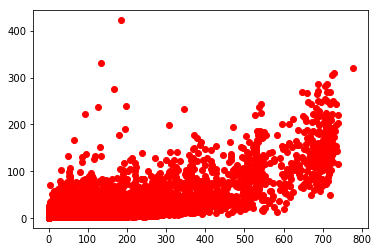

In [448]:
plt.plot( timestamps['len,min'].values, timestamps['timestamp']['count'].values, 'ro')

plt.show()

In [481]:
timestamps['freq'] = timestamps['timestamp']['count']/timestamps['len,min']

In [499]:
t = timestamps.loc[(timestamps['timestamp']['count']> 1) &  (timestamps['len,min'] >= 0.1)]
print(t['timestamp']['count'].min(), t['timestamp']['count'].max(), t['timestamp']['count'].mean(),t['timestamp']['count'].median())
print(t['len,min'].min(), t['len,min'].max(),t['len,min'].mean(),t['len,min'].median())

2 422 3.731507816121013 2.0
0.1 776.733383333 15.333285914873832 3.77665


In [500]:
t.shape

(379728, 15)

In [501]:
print( t['delta1']['mean'].mean(),t['delta1']['median'].mean())

4.1572780422657996 3.191724878070632


In [502]:
print( t['delta1']['mean'].median(),t['delta1']['median'].median())

1.2657500000000002 0.879


In [503]:
print(t['freq'].min(), t['freq'].max(),t['freq'].mean(),t['freq'].median())

0.0161764887273 74.5526838966 1.8506269837786302 0.7900176876791014


In [459]:
t.shape

(387786, 14)

In [619]:
t.head()

timestamp                                                    \
                      mean        median            max            min count   
ssid                                                                           
b'0'          1.442005e+12  1.442005e+12  1442004917175  1442004589439     3   
b'100'        1.441756e+12  1.441756e+12  1441756374884  1441756135990     4   
b'10000'      1.435889e+12  1.435889e+12  1435889141392  1435888834563     6   
b'1000001_1'  1.437770e+12  1.437770e+12  1437770157029  1437769095303     3   
b'1000003'    1.439455e+12  1.439455e+12  1439454877509  1439454764125     2   

                        delta1                                       len,min  \
             nunique      mean  median     max  min count nunique              
ssid                                                                           
b'0'               3  1.820667  2.6260   2.836  0.0     3       3   5.462267   
b'100'             4  0.995250  0.6245   2.732  0.0     4       4   3.981567   
b'10000'           6  0.852167  0.2100   3.012  0.0     6       6   5.113817   
b'1000001_1'       3  5.898667  1.0380  16.658  0.0     3       3  17.695433   
b'1000003'         2  0.945000  0.9450   1.890  0.0     2       2   1.889733   

                  friq      freq  
                                  
ssid                              
b'0'          0.549223  0.549223  
b'100'        1.004630  1.004630  
b'10000'      1.173292  1.173292  
b'1000001_1'  0.169535  0.169535  
b'1000003'    1.058350  1.058350

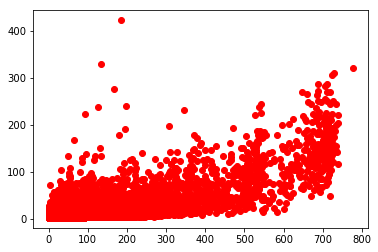

In [460]:
plt.plot( t['len,min'].values, t['delta1']['count'].values, 'ro')
plt.show()

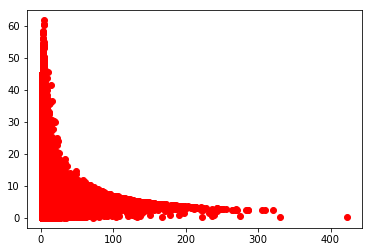

In [794]:
plt.plot(  t['delta1']['count'].values, t['delta1']['mean'].values,'ro')
plt.show()

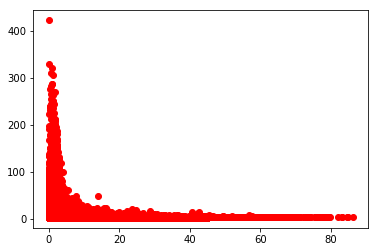

In [624]:
plt.plot( t['delta1']['median'].values, t['delta1']['count'].values, 'ro')
plt.show()

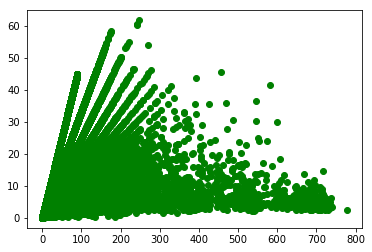

In [633]:
plt.plot( t['len,min'].values, t['delta1']['mean'].values, 'go')
plt.show()


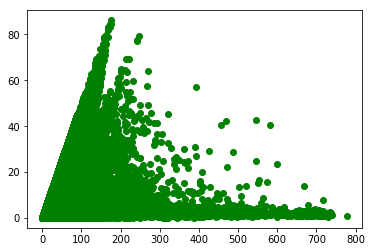

In [634]:
plt.plot( t['len,min'].values, t['delta1']['median'].values , 'go')
plt.show()

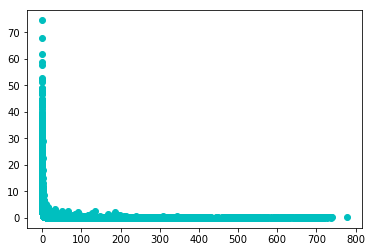

In [635]:
plt.plot( t['len,min'].values, t['freq'].values, 'co')
plt.show()

In [636]:
t_s = t.loc[(t['len,min'] > 3.6)]

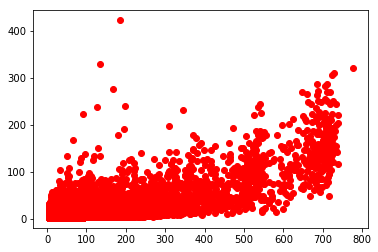

In [82]:
plt.plot( t_s['len,min'].values, t_s['timestamp']['count'].values, 'ro')
plt.show()

In [83]:
t_s.shape

(193788, 5)

In [84]:
r = pd.concat([t['len,min'], t['timestamp']['count']], axis=1)


In [85]:
X = r['len,min']
Y = r['count']

In [86]:
#t['len,min'].values.reshape((t['len,min'].values.shape[0],1)),t['timestamp']['count'].values.reshape((t['timestamp']['count'].values.shape[0],1)))

In [87]:
r.values[:, 0]
r.values[:, 1]

array([ 3.,  4.,  6., ...,  2.,  2.,  4.])

In [88]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [89]:
##возьмем 10 примеров ссесий и визуализируем

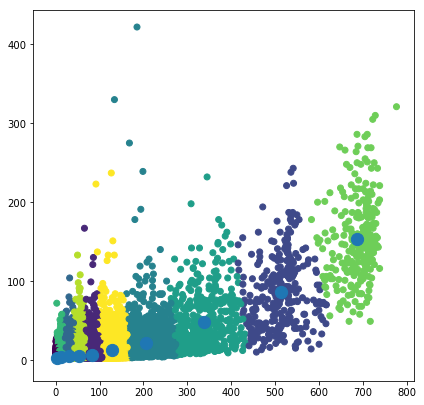

CPU times: user 36 s, sys: 7.72 s, total: 43.7 s
Wall time: 43.5 s


In [90]:
%%time
plt.subplots(figsize=(15, 15))
model = KMeans(n_clusters=10,random_state=42 )
y_pred = model.fit_predict(r.values)

plt.subplot(221)
plt.scatter(r.values[:, 0], r.values[:, 1], c=y_pred)
centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=150)
plt.show()

In [91]:
sessions = []
for s in centers:
    sessions.append(r.loc[ (r['len,min'] >= s[0])&( r['count'] >= s[1])].sort_values(['count','len,min'], ascending=[True, True]).iloc[0].name)

In [92]:
print(sessions)

[b'1253467', b'1377259', b'836468', b'1089278_1', b'1256640_1', b'389532_1', b'2646', b'548772_8', b'1042619', b'218828_24']


In [93]:
e_ = e.loc[e.ssid.isin(sessions)].sort_values([ 'timestamp','ssid'], ascending=[True, True])

In [94]:
e_['event'].replace('view', 0,inplace=True)
e_['event'].replace('addtocart', 10,inplace=True)
e_['event'].replace('transaction', 20,inplace=True)

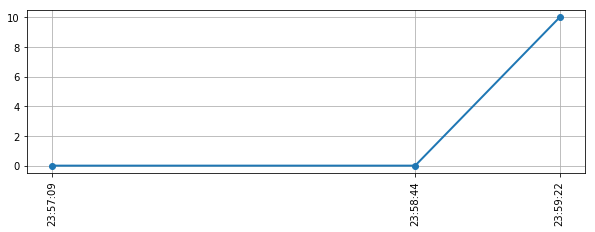

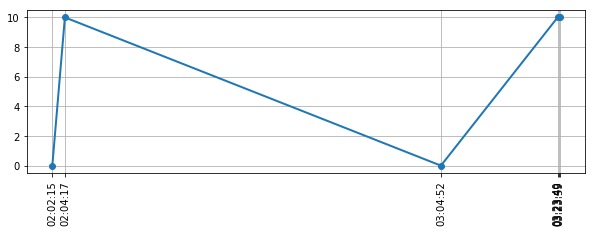

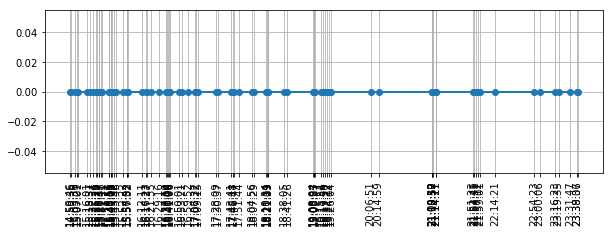

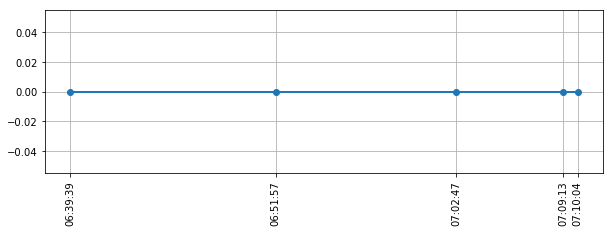

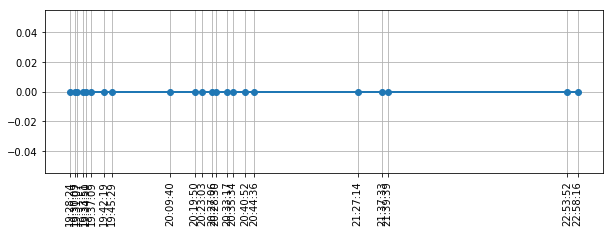

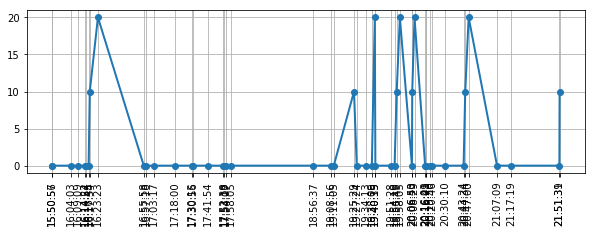

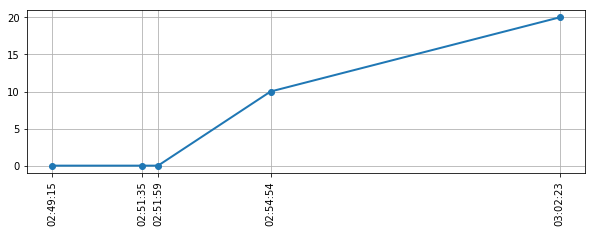

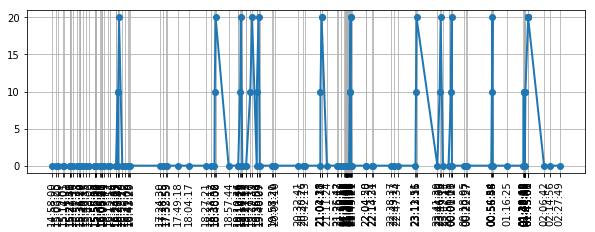

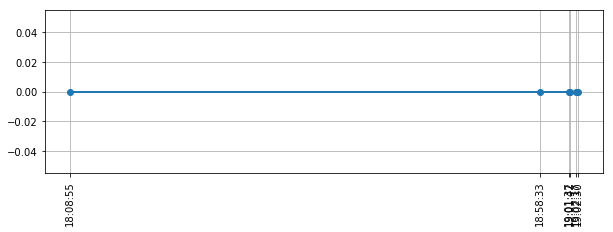

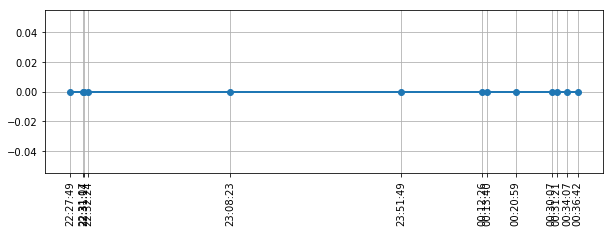

In [95]:
import datetime

def t(time):
    return datetime.datetime.utcfromtimestamp(np.round(time/1000)).strftime('%H:%M:%S')

session = []
for i in sessions:
    session.append(e_.loc[e_.ssid == i])
for u in session:
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.grid(True)
    ax.plot((u.timestamp), u.event,'o-', linewidth=2)
    u['time'] = u.timestamp.apply(t)
    labels =   u['time'] 
    plt.xticks((u.timestamp), labels, rotation='vertical')
    
    
    
#     df.apply(f, axis=1)
plt.show()

In [96]:
#datetime.utcfromtimestamp(posix_time).strftime('%Y-%m-%dT%H:%M:%SZ')

### events analys

In [97]:
e.head()

,timestamp,visitorid,event,itemid,transactionid,delta,delta1,ssid
0,1442004589439,0,view,285930,-1,0.0,0.000,b'0'
1,1442004759591,0,view,357564,-1,3.0,2.836,b'0'
2,1442004917175,0,view,67045,-1,3.0,2.626,b'0'
3,1438969904567,2,view,325215,-1,0.0,0.000,b'2'
4,1438970013790,2,view,325215,-1,2.0,1.820,b'2'


In [98]:
#бинаризуем категории событий
events_ = pd.get_dummies(e, columns=['event'])
events_.head()

,timestamp,visitorid,itemid,transactionid,delta,delta1,ssid,event_addtocart,event_transaction,event_view
0,1442004589439,0,285930,-1,0.0,0.000,b'0',0,0,1
1,1442004759591,0,357564,-1,3.0,2.836,b'0',0,0,1
2,1442004917175,0,67045,-1,3.0,2.626,b'0',0,0,1
3,1438969904567,2,325215,-1,0.0,0.000,b'2',0,0,1
4,1438970013790,2,325215,-1,2.0,1.820,b'2',0,0,1


In [99]:
%%time
event =  events_[['ssid','event_addtocart','event_transaction','event_view']].groupby('ssid').agg(['sum','count'])

CPU times: user 1.04 s, sys: 128 ms, total: 1.17 s
Wall time: 1.18 s


In [100]:
event.head()

event_addtocart       event_transaction       event_view      
                         sum count               sum count        sum count
ssid                                                                       
b'0'                       0     3                 0     3        3.0     3
b'100'                     0     4                 0     4        4.0     4
b'10000'                   0     6                 0     6        6.0     6
b'1000001'                 0     1                 0     1        1.0     1
b'1000001_1'               0     3                 0     3        3.0     3

In [537]:
print(event['event_view']['sum'].mean(), event['event_view']['sum'].median())

2.3515175221453877 2.0


In [539]:
print(event['event_addtocart']['sum'].mean(), event['event_addtocart']['sum'].median())

0.0943217714616 0.0


In [538]:
print(event['event_transaction']['sum'].mean(), event['event_transaction']['sum'].median())

0.0316072192623 0.0


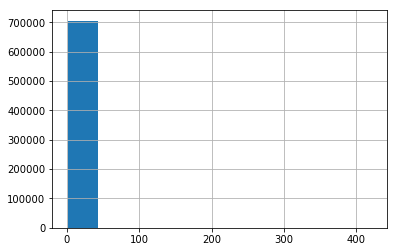

In [101]:
event.loc[event['event_view']['sum'] > 0]['event_view']['sum'].hist()

In [102]:
event.loc[event['event_view']['sum'] > 0]['event_view']['sum'].shape[0]

705837

In [103]:
#интересно то что это кол-во меньше общего кол-ва поситителей
#те есть посетители которые не смотря сразу добавляли или покупали товары -
#этот факт указывает на то что в данных есть шум
e.ssid.unique().shape[0]-event.loc[event['event_view']['sum'] > 0]['event_view']['sum'].shape[0]

2324

In [104]:
print(event.loc[event['event_view']['sum'] > 0]['event_view']['sum'].mean(),event.loc[event['event_view']['sum'] > 0]['event_view']['sum'].median(),event.loc[event['event_view']['sum'] > 0]['event_view']['sum'].max() )

2.35925999912161 2.0 422.0


In [105]:
event.loc[event['event_addtocart']['sum'] > 0]['event_addtocart']['sum'].shape[0]

39621

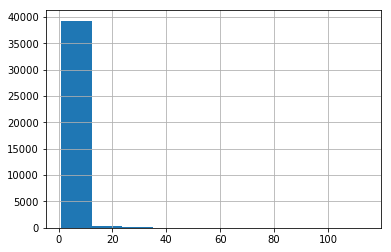

In [106]:
event.loc[event['event_addtocart']['sum'] > 0]['event_addtocart']['sum'].hist()

In [107]:
print(event.loc[event['event_addtocart']['sum'] > 0]['event_addtocart']['sum'].mean(),event.loc[event['event_addtocart']['sum'] > 0]['event_addtocart']['sum'].median(),event.loc[event['event_addtocart']['sum'] > 0]['event_addtocart']['sum'].max() )

1.68584841372 1.0 114


In [108]:
event.loc[event['event_transaction']['sum'] > 0]['event_transaction']['sum'].shape[0]

13193

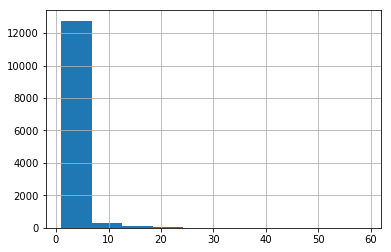

In [109]:
event.loc[event['event_transaction']['sum'] > 0]['event_transaction']['sum'].hist()

In [110]:
print(event.loc[event['event_transaction']['sum'] > 0]['event_transaction']['sum'].mean(),event.loc[event['event_transaction']['sum'] > 0]['event_transaction']['sum'].median(),event.loc[event['event_transaction']['sum'] > 0]['event_transaction']['sum'].max() )

1.6965815205 1.0 59


In [111]:
event.head(10)

event_addtocart       event_transaction       event_view      
                         sum count               sum count        sum count
ssid                                                                       
b'0'                       0     3                 0     3        3.0     3
b'100'                     0     4                 0     4        4.0     4
b'10000'                   0     6                 0     6        6.0     6
b'1000001'                 0     1                 0     1        1.0     1
b'1000001_1'               0     3                 0     3        3.0     3
b'1000001_2'               0     1                 0     1        1.0     1
b'1000003'                 0     2                 0     2        2.0     2
b'1000007'                 0     1                 0     1        1.0     1
b'1000007_1'               0     1                 0     1        1.0     1
b'1000015'                 0     2                 0     2        2.0     2

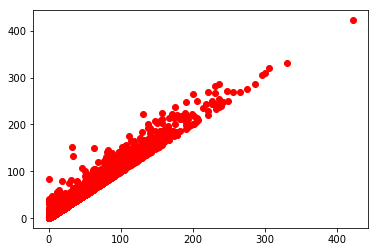

In [112]:
plt.plot(event['event_view']['sum'], event['event_view']['count'], 'ro')
plt.show()

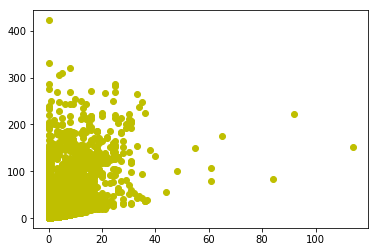

In [113]:
plt.plot(event['event_addtocart']['sum'], event['event_view']['count'], 'yo')
plt.show()

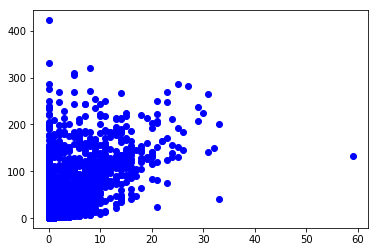

In [114]:
plt.plot(event['event_transaction']['sum'], event['event_view']['count'], 'bo')
plt.show()

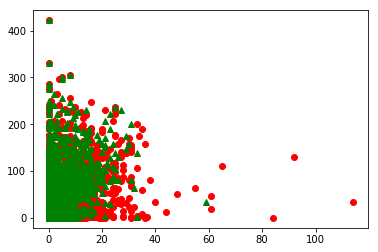

In [115]:
plt.plot( event['event_addtocart']['sum'], event['event_view']['sum'],'ro')
plt.plot(event['event_transaction']['sum'], event['event_view']['sum'], 'g^')
plt.show()

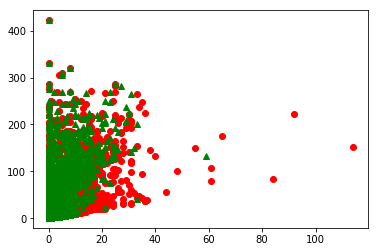

In [116]:
plt.plot(event['event_addtocart']['sum'], event['event_view']['count'],'ro')
plt.plot(event['event_transaction']['sum'], event['event_view']['count'], 'g^')
plt.show()

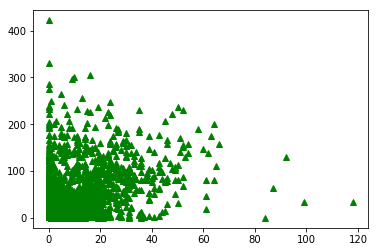

In [117]:
plt.plot(event['event_transaction']['sum'] + event['event_addtocart']['sum'], event['event_view']['sum'], 'g^')
plt.show()

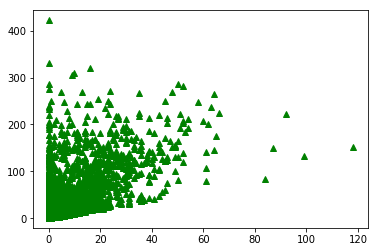

In [118]:
plt.plot(event['event_transaction']['sum'] + event['event_addtocart']['sum'], event['event_view']['count'], 'g^')
plt.show()

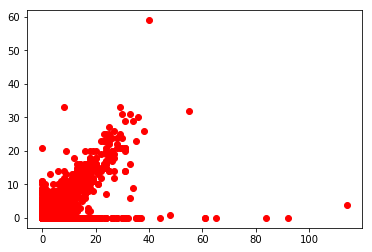

In [119]:
plt.plot(event['event_addtocart']['sum'], event['event_transaction']['sum'], 'ro')
plt.show()

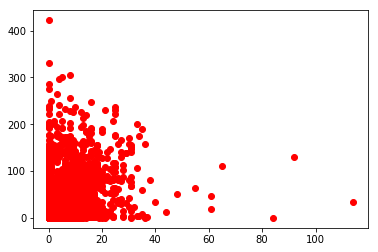

In [120]:
plt.plot(event['event_addtocart']['sum'], event['event_view']['sum'], 'ro')
plt.show()

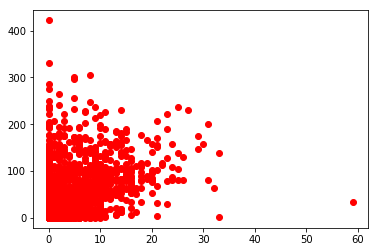

In [121]:
plt.plot(event['event_transaction']['sum'], event['event_view']['sum'], 'ro')
plt.show()

In [122]:
#кол-во сессий
event.shape

(708161, 6)

In [123]:
#кол-во сессий с view
v_ = event.loc[event['event_view']['sum']>0]
v_.shape

(705837, 6)

In [124]:
#кол-во сессий с event_addtocart
add_ = event.loc[event['event_addtocart']['sum']>0]
add_.shape

(39621, 6)

In [125]:
#кол-во сессий с event_transaction
trns_ = event.loc[event['event_transaction']['sum']>0]
trns_.shape

(13193, 6)

In [126]:
v_add = v_.loc[event['event_addtocart']['sum']>0]
v_add.shape

(37572, 6)

In [127]:
v_.loc[event['event_transaction']['sum']>0].shape

(12287, 6)

In [128]:
v_add_tran = v_add.loc[event['event_transaction']['sum']>0]
v_add_tran.shape

(10758, 6)

In [554]:
print(v_add_tran['event_view']['sum'].mean(), v_add_tran['event_view']['sum'].median())

print(v_add_tran['event_addtocart']['sum'].mean(), v_add_tran['event_addtocart']['sum'].median())

print(v_add_tran['event_transaction']['sum'].mean(), v_add_tran['event_transaction']['sum'].median())

print(v_add_tran['event_transaction']['count'].mean(), v_add_tran['event_transaction']['count'].median())

9.513571295779885 3.0
2.08914296338 1.0
1.80089235917 1.0
13.403606618330544 5.0


In [541]:
v_add_no_t = v_.loc[(event['event_addtocart']['sum']>0)&(event['event_transaction']['sum']==0)]

In [553]:
v_add_no_t.shape

(26814, 6)

In [556]:
print(v_add_no_t['event_view']['sum'].mean(), v_add_no_t['event_view']['sum'].median())

print(v_add_no_t['event_addtocart']['sum'].mean(), v_add_no_t['event_addtocart']['sum'].median())

print(v_add_no_t['event_transaction']['sum'].mean(), v_add_no_t['event_transaction']['sum'].median())

print(v_add_no_t['event_transaction']['count'].mean(), v_add_no_t['event_transaction']['count'].median())

3.991161333631685 2.0
1.52155590363 1.0
0.0 0.0
5.512717237264115 3.0


In [543]:
v_only = v_.loc[(event['event_addtocart']['sum']==0)&(event['event_transaction']['sum']==0)]

In [546]:
v_only.shape

(666736, 6)

In [557]:
print(v_only['event_view']['sum'].mean(), v_only['event_view']['sum'].median())

print(v_only['event_transaction']['count'].mean(), v_only['event_transaction']['count'].median())

2.1762166734659596 2.0
2.1762166734659596 2.0


In [549]:
v_only['event_view']['count'].mean()

2.1762166734659596

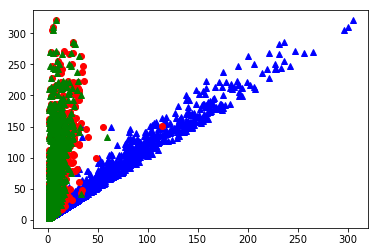

In [129]:
plt.plot(v_add_tran['event_view']['sum'], v_add_tran['event_view']['count'], 'b^')
plt.plot(v_add_tran['event_addtocart']['sum'], v_add_tran['event_view']['count'],'ro')
plt.plot(v_add_tran['event_transaction']['sum'], v_add_tran['event_view']['count'], 'g^')
plt.show()

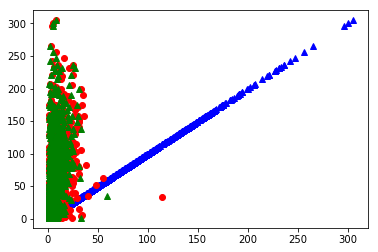

In [130]:
plt.plot(v_add_tran['event_view']['sum'], v_add_tran['event_view']['sum'], 'b^')
plt.plot(v_add_tran['event_addtocart']['sum'], v_add_tran['event_view']['sum'],'ro')
plt.plot(v_add_tran['event_transaction']['sum'], v_add_tran['event_view']['sum'], 'g^')
plt.show()

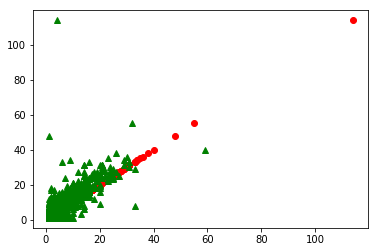

In [131]:
plt.plot(v_add_tran['event_addtocart']['sum'], v_add_tran['event_addtocart']['sum'],'ro')
plt.plot(v_add_tran['event_transaction']['sum'], v_add_tran['event_addtocart']['sum'], 'g^')
plt.show()

### items analys

In [132]:
e.head()

,timestamp,visitorid,event,itemid,transactionid,delta,delta1,ssid
0,1442004589439,0,view,285930,-1,0.0,0.000,b'0'
1,1442004759591,0,view,357564,-1,3.0,2.836,b'0'
2,1442004917175,0,view,67045,-1,3.0,2.626,b'0'
3,1438969904567,2,view,325215,-1,0.0,0.000,b'2'
4,1438970013790,2,view,325215,-1,2.0,1.820,b'2'


In [133]:
%%time
view = e.loc[e['event'] == 'view']
item_view =  view[['ssid','itemid']].groupby('ssid').agg(['count','nunique'])

CPU times: user 1.69 s, sys: 249 ms, total: 1.94 s
Wall time: 2 s


In [134]:
item_view.shape

(705837, 2)

In [135]:
print(item_view['itemid']['count'].mean(), item_view['itemid']['count'].median())

2.35925999912161 2.0


In [136]:
print(item_view['itemid']['nunique'].mean(), item_view['itemid']['nunique'].median())

1.8433264337233668 1.0


In [137]:
item_view.loc[ (item_view['itemid']['count']-item_view['itemid']['nunique']) > 0].shape

(206472, 2)

In [138]:
item_view.loc[ (item_view['itemid']['count']-item_view['itemid']['nunique']) == 0].shape

(499365, 2)

In [139]:
item_view.loc[ (item_view['itemid']['count']-item_view['itemid']['nunique']) == 0].shape

(499365, 2)

In [140]:
e.loc[e.ssid == b'0']

,timestamp,visitorid,event,itemid,transactionid,delta,delta1,ssid
0,1442004589439,0,view,285930,-1,0.0,0.000,b'0'
1,1442004759591,0,view,357564,-1,3.0,2.836,b'0'
2,1442004917175,0,view,67045,-1,3.0,2.626,b'0'


In [141]:
#сессий в которых пользователи просматривают 1 обьект по 1-му разу больше.

In [142]:
%%time
addtocart = e.loc[e['event'] == 'addtocart']
item_addtocart =  addtocart[['ssid','itemid']].groupby('ssid').agg(['count','nunique'])

CPU times: user 222 ms, sys: 9.82 ms, total: 232 ms
Wall time: 231 ms


In [143]:
item_addtocart.shape

(39621, 2)

In [144]:
print(item_addtocart['itemid']['count'].mean(), item_addtocart['itemid']['count'].median())

1.685848413719997 1.0


In [145]:
print(item_addtocart['itemid']['nunique'].mean(), item_addtocart['itemid']['nunique'].median())

1.5389566139168622 1.0


In [146]:
item_addtocart.loc[ (item_addtocart['itemid']['count'] -item_addtocart['itemid']['nunique']) > 0].shape

(3467, 2)

In [147]:
item_addtocart.loc[ (item_addtocart['itemid']['count'] - item_addtocart['itemid']['nunique']) == 0].shape

(36154, 2)

In [148]:
#если говорить о добавлении в корзину то в большенстве случаем в корзину попадает 1-н товар по 1-раз


In [149]:
%%time
transaction = e.loc[e['event'] == 'transaction']
item_transaction =  transaction[['ssid','itemid']].groupby('ssid').agg(['count','nunique'])

CPU times: user 194 ms, sys: 4.04 ms, total: 198 ms
Wall time: 198 ms


In [150]:
item_transaction.shape

(13193, 2)

In [151]:
print(item_transaction['itemid']['count'].mean(), item_transaction['itemid']['count'].median())

1.6965815205032972 1.0


In [152]:
print(item_transaction['itemid']['nunique'].mean(), item_transaction['itemid']['nunique'].median())

1.6398089896157053 1.0


In [153]:
item_transaction.loc[ (item_transaction['itemid']['count'] - item_transaction['itemid']['nunique']) > 0].shape

(493, 2)

In [154]:
item_transaction.loc[ (item_transaction['itemid']['count'] - item_transaction['itemid']['nunique']) == 0].shape

(12700, 2)

In [155]:
#по транзакция также как и с addtocard

### items explore

In [ ]:
item_properties.itemid.unique().shape

In [ ]:
item_properties.property.unique().shape

In [ ]:
#пример свойств 1-ого обьекта - c сортировкой по времени
#
i = item_properties.loc[(item_properties.itemid == 318909)]
i.sort_values(by = 'timestamp').head(5)

In [ ]:
#item_properties.loc[(item_properties.itemid == 318909)]

In [ ]:
e.head()

In [ ]:
item_properties.loc[(item_properties.itemid == 76740)].shape[0]

In [ ]:
['visitorid', 'timestamp']

In [156]:
categories = item_properties.loc[item_properties.property =='categoryid'].sort_values(['itemid', 'timestamp'], ascending = [False,False])

In [157]:
categories.shape

(788214, 4)

In [158]:
categories = categories.loc[categories.itemid.isin(e.itemid.unique())]

In [159]:
%%time
categories.loc[(categories.itemid == 318909)]

CPU times: user 1.71 ms, sys: 533 µs, total: 2.25 ms
Wall time: 1.4 ms


,timestamp,itemid,property,value
7474279,1435460400000,318909,categoryid,1022


In [160]:
err = np.array(e[['timestamp','itemid']])

In [161]:
err.shape

(1754431, 2)

In [165]:
%%time
cat = []
for i in err:
    cat.append(get_cat(i[0],i[1]))

CPU times: user 41min 30s, sys: 13.5 s, total: 41min 43s
Wall time: 41min 47s


In [167]:
len(cat)

1754431

In [168]:
e['cat'] = cat

In [355]:
def get_cat(timestamp,itemid):
    result = -1
    i_ = categories.loc[(categories.itemid == itemid)&(categories.timestamp <= timestamp)]
    ##ЭТО не верно!!! Нужно брать самое близкое значение по timestamp
    if i_.shape[0] != 0:
        result = int(i_.iloc[0].value)
    return result
def tt(s):
    print(s[0],s[1])
    return get_cat(s[0],s[1])

In [ ]:
e.shape

In [ ]:
%%time
get_cat(1437274886274,76740)

In [ ]:
%%time
e['cat'] = e[['timestamp','itemid']].apply(tt,axis=1)

In [ ]:
##

In [177]:
e.iloc[0]['cat']

1188

In [187]:
%%time
#нужно переписать
d_ = np.zeros(e.shape[0])
session = '0'
dist = e.iloc[0]['cat']
for index, row in e.iterrows():
    if session != row['ssid']:
        dist = row['cat']
    d_[index] = item_distance(row['cat'],dist)
    dist = row['cat'] 
    session = row['ssid']
    #print( s[index])
    #print(d_[index])

CPU times: user 1h 21min 3s, sys: 29.4 s, total: 1h 21min 33s
Wall time: 1h 21min 24s


In [189]:
d_.shape

(1754431,)

In [190]:
e['dist'] = d_

In [191]:
e.head()

,timestamp,visitorid,event,itemid,transactionid,delta,delta1,ssid,cat,dist
0,1442004589439,0,view,285930,-1,0.0,0.000,b'0',1188,0.0
1,1442004759591,0,view,357564,-1,3.0,2.836,b'0',256,6.0
2,1442004917175,0,view,67045,-1,3.0,2.626,b'0',333,6.0
3,1438969904567,2,view,325215,-1,0.0,0.000,b'2',299,0.0
4,1438970013790,2,view,325215,-1,2.0,1.820,b'2',299,0.0


In [192]:
e.to_csv('df.csv')

In [772]:
%%time
item_cat = e[['timestamp','cat','dist','ssid','delta1']].groupby('ssid').agg(['max','min','mean','median','sum','count','nunique'])

CPU times: user 2.84 s, sys: 1.01 s, total: 3.85 s
Wall time: 4.35 s


In [773]:
item_cat['len,min'] = (item_cat['timestamp']['max'] - item_cat['timestamp']['min'])/(1000*60)

In [774]:
item_cat.head()

timestamp                                             \
                        max            min          mean        median   
ssid                                                                     
b'0'          1442004917175  1442004589439  1.442005e+12  1.442005e+12   
b'100'        1441756374884  1441756135990  1.441756e+12  1.441756e+12   
b'10000'      1435889141392  1435888834563  1.435889e+12  1.435889e+12   
b'1000001'    1436292734953  1436292734953  1.436293e+12  1.436293e+12   
b'1000001_1'  1437770157029  1437769095303  1.437770e+12  1.437770e+12   

                                            cat                       ...      \
                        sum count nunique   max   min         mean    ...       
ssid                                                                  ...       
b'0'          4326014266205     3       3  1188   256   592.333333    ...       
b'100'        5767024991216     4       4   124   124   124.000000    ...       
b'10000'      8615333678130     6       6  1120  1120  1120.000000    ...       
b'1000001'    1436292734953     1       1   683   683   683.000000    ...       
b'1000001_1'  4313309347105     3       3  1279   683   881.666667    ...       

              dist          delta1                                       \
             count nunique     max  min      mean  median     sum count   
ssid                                                                      
b'0'             3       2   2.836  0.0  1.820667  2.6260   5.462     3   
b'100'           4       1   2.732  0.0  0.995250  0.6245   3.981     4   
b'10000'         6       1   3.012  0.0  0.852167  0.2100   5.113     6   
b'1000001'       1       1   0.000  0.0  0.000000  0.0000   0.000     1   
b'1000001_1'     3       2  16.658  0.0  5.898667  1.0380  17.696     3   

                        len,min  
             nunique             
ssid                             
b'0'               3   5.462267  
b'100'             4   3.981567  
b'10000'           6   5.113817  
b'1000001'         1   0.000000  
b'1000001_1'       3  17.695433  

[5 rows x 29 columns]

In [566]:
e.head()

,timestamp,visitorid,event,itemid,transactionid,delta,delta1,ssid,cat,dist
0,1442004589439,0,view,285930,-1,0.0,0.000,b'0',1188,0.0
1,1442004759591,0,view,357564,-1,3.0,2.836,b'0',256,6.0
2,1442004917175,0,view,67045,-1,3.0,2.626,b'0',333,6.0
3,1438969904567,2,view,325215,-1,0.0,0.000,b'2',299,0.0
4,1438970013790,2,view,325215,-1,2.0,1.820,b'2',299,0.0


In [ ]:
# Кол-во сессий 708161
# Кол-во сессий в которых взаимодействия происходит с 1-м элементом 600288
# Кол-во сессий в которых взаимодействия происходит > чем 1-м элементом 107873

In [606]:
print(item_cat['cat']['nunique'].mean() , item_cat['cat']['nunique'].median() )

1.2528295119330208 1.0


In [562]:
item_cat.loc[item_cat['cat']['nunique'] == 1].shape

(600288, 10)

In [564]:
item_cat.loc[item_cat['cat']['nunique'] > 1].shape

(107873, 10)

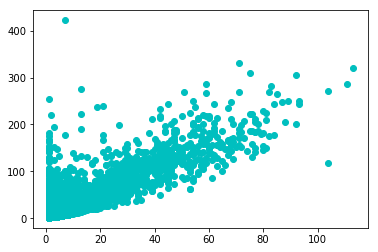

In [611]:
plt.plot(item_cat['cat']['nunique'], item_cat['cat']['count'], 'co')
plt.show()

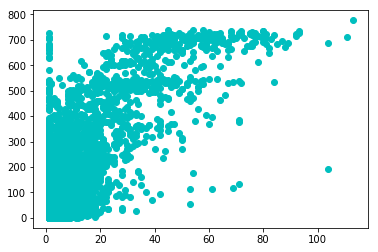

In [649]:
plt.plot(item_cat['cat']['nunique'], item_cat['len,min'], 'co')
plt.show()

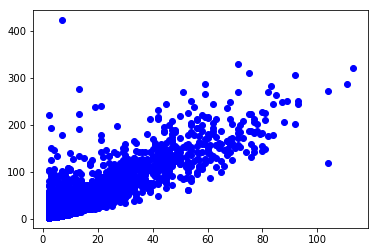

In [603]:
item_cat_ = item_cat.loc[(item_cat['cat']['nunique'] > 1)&(item_cat['cat']['count'] > 1)]
plt.plot(item_cat_['cat']['nunique'], item_cat_['cat']['count'], 'bo')
plt.show()

In [605]:
print(item_cat_['cat']['nunique'].mean() , item_cat_['cat']['nunique'].median() )

2.6597665773641226 2.0


In [607]:
item_cat.loc[item_cat['dist']['sum'] > 0].shape

(107873, 10)

In [637]:
item_cat.head()

cat                                  dist               \
                     mean  median   sum count nunique      mean median   sum   
ssid                                                                           
b'0'           592.333333   333.0  1777     3       3  4.000000    6.0  12.0   
b'100'         124.000000   124.0   496     4       1  0.000000    0.0   0.0   
b'10000'      1120.000000  1120.0  6720     6       1  0.000000    0.0   0.0   
b'1000001'     683.000000   683.0   683     1       1  0.000000    0.0   0.0   
b'1000001_1'   881.666667   683.0  2645     3       2  0.666667    0.0   2.0   

                            
             count nunique  
ssid                        
b'0'             3       2  
b'100'           4       1  
b'10000'         6       1  
b'1000001'       1       1  
b'1000001_1'     3       2

In [767]:
print(item_cat['dist']['sum'].median(),item_cat['dist']['sum'].mean() )
print(dist_['dist']['sum'].median(),dist_['dist']['sum'].mean() )
dist_.shape

0.0 1.623844012872779
5.0 11.721038968925052


(65873, 22)

In [768]:
print(item_cat['dist']['mean'].median(),item_cat['dist']['mean'].mean() )
print(dist_['dist']['mean'].median(),dist_['dist']['mean'].mean() )

0.0 0.2691945847616841
2.0 2.1687402825888014


In [769]:
print(item_cat['dist']['median'].median(),item_cat['dist']['median'].mean() )
print(dist_['dist']['median'].median(),dist_['dist']['median'].mean() )

0.0 0.22676128733437736
2.0 2.4377742018733017


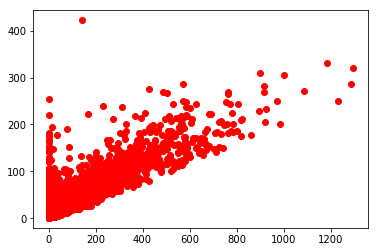

In [613]:
plt.plot(item_cat['dist']['sum'], item_cat['dist']['count'], 'ro')
plt.show()

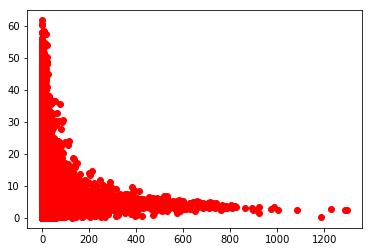

In [802]:
plt.plot(item_cat['dist']['sum'], item_cat['delta1']['mean'], 'ro')
plt.show()

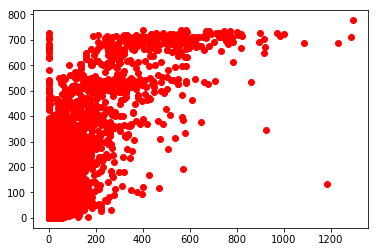

In [788]:
plt.plot(item_cat['dist']['sum'], item_cat['delta1']['sum'], 'ro')
plt.show()

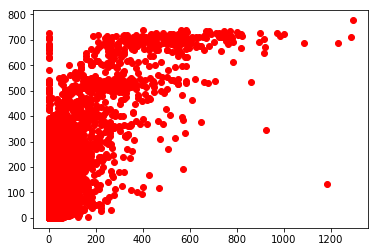

In [650]:
plt.plot(item_cat['dist']['sum'], item_cat['len,min'], 'ro')
plt.show()

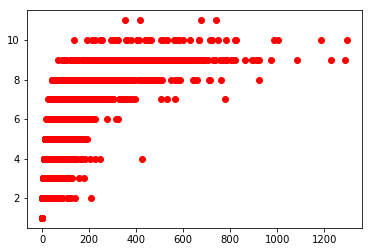

In [659]:
plt.plot(item_cat['dist']['sum'], item_cat['dist']['nunique'], 'ro')
plt.show()

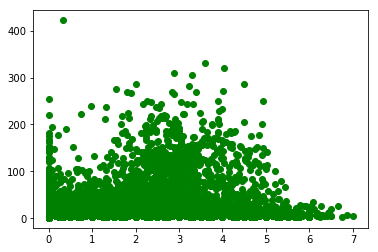

In [609]:
plt.plot(item_cat['dist']['mean'], item_cat['dist']['count'], 'go')
plt.show()

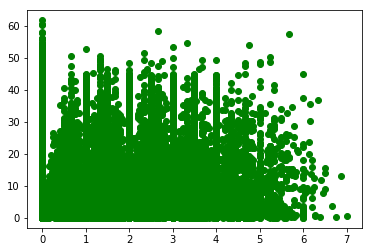

In [775]:
plt.plot(item_cat['dist']['mean'], item_cat['delta1']['mean'], 'go')
plt.show()

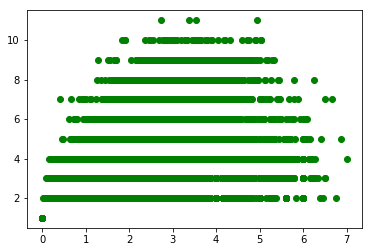

In [657]:
plt.plot(item_cat['dist']['mean'], item_cat['dist']['nunique'], 'go')
plt.show()

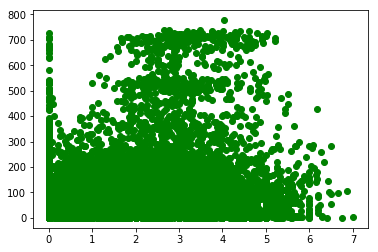

In [652]:
plt.plot(item_cat['dist']['mean'], item_cat['len,min'], 'go')
plt.show()

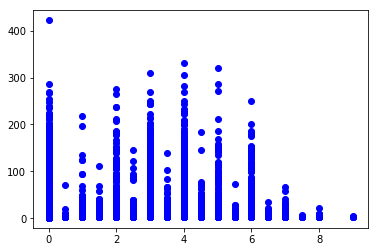

In [610]:
plt.plot(item_cat['dist']['median'], item_cat['dist']['count'], 'bo')
plt.show()

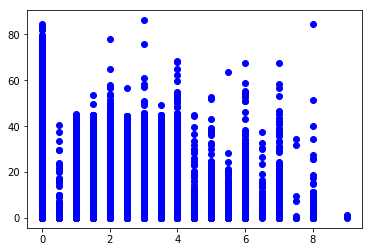

In [787]:
plt.plot(item_cat['dist']['median'], item_cat['delta1']['median'], 'bo')
plt.show()

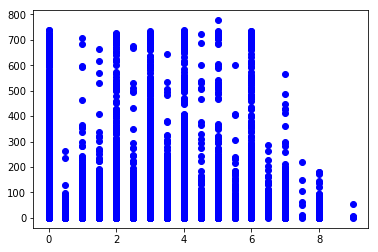

In [653]:
plt.plot(item_cat['dist']['median'], item_cat['len,min'], 'bo')
plt.show()

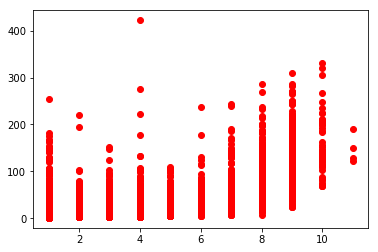

In [364]:
plt.plot(item_cat['dist']['nunique'], item_cat['dist']['count'], 'ro')
plt.show()

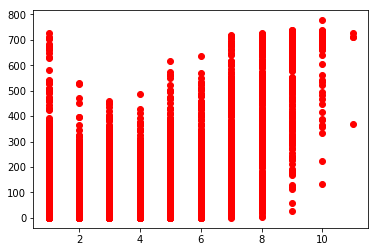

In [654]:
plt.plot(item_cat['dist']['nunique'], item_cat['len,min'], 'ro')
plt.show()

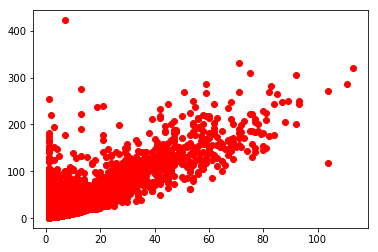

In [365]:
plt.plot(item_cat['cat']['nunique'], item_cat['cat']['count'], 'ro')
plt.show()

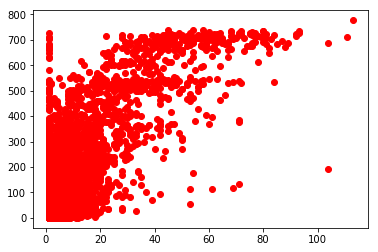

In [656]:
plt.plot(item_cat['cat']['nunique'], item_cat['len,min'], 'ro')
plt.show()

In [214]:
item_cat.shape

(708161, 6)

In [216]:
item_cat.loc[(item_cat['dist']['count'] == 1)].shape

(320221, 6)

In [ ]:
Кол-во сессий: 708161
Кол-во 1-ых сессий: 320221
Кол-во не 1-ых сессий : 387940

In [777]:
dist_ = item_cat.loc[(item_cat['dist']['count'] > 1)&(item_cat['dist']['median'] > 0)]

In [778]:
dist_.shape

(65873, 29)

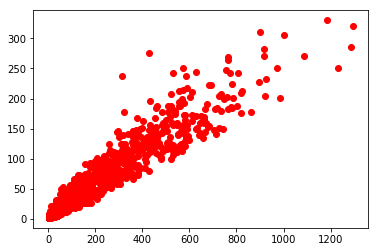

In [779]:
plt.plot(dist_['dist']['sum'], dist_['dist']['count'], 'ro')
plt.show()

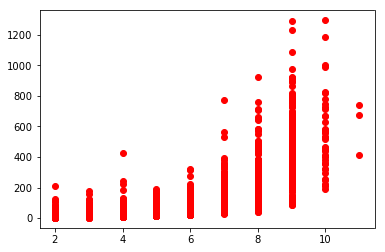

In [780]:
plt.plot( dist_['dist']['nunique'],dist_['dist']['sum'], 'ro')
plt.show()

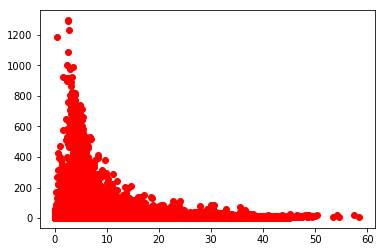

In [784]:
plt.plot( dist_['delta1']['mean'],dist_['dist']['sum'], 'ro')
plt.show()

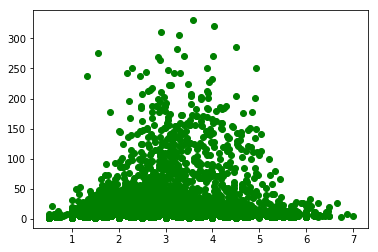

In [781]:
plt.plot(dist_['dist']['mean'], dist_['dist']['count'], 'go')
plt.show()

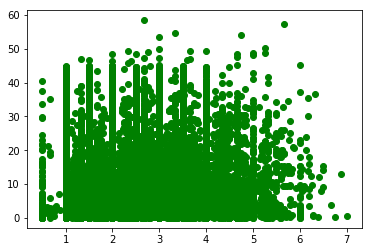

In [782]:
plt.plot(dist_['dist']['mean'], dist_['delta1']['mean'], 'go')
plt.show()

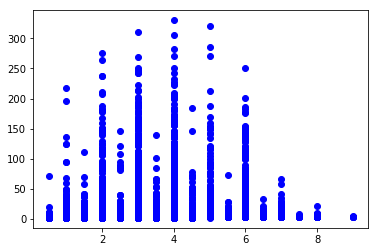

In [783]:
plt.plot(dist_['dist']['median'], dist_['dist']['count'], 'bo')
plt.show()

In [761]:
zero_dist = item_cat.loc[(item_cat['dist']['sum'] == 0)&(item_cat['dist']['count'] > 1)]

In [327]:
zero_dist.shape
#кол-во ссесий в которых взаимодействие проиходит с обьектами одной категории

(280067, 6)

In [346]:
zero_dist.tail(10)

cat               dist              
              sum count nunique  sum count nunique
ssid                                              
b'99997'     6306     6       1  0.0     6       1
b'999972_1'  3156     2       1  0.0     2       1
b'999973'    2466     2       1  0.0     2       1
b'999981'    2392     2       1  0.0     2       1
b'999986_1'  1320     4       1  0.0     4       1
b'999989'      -2     2       1  0.0     2       1
b'99999'       -2     2       1  0.0     2       1
b'999996_1'  2768     2       1  0.0     2       1
b'999996_3'  1236     2       1  0.0     2       1
b'999998_1'  2260     4       1  0.0     4       1

In [344]:
e.loc[e.ssid == b'10000']

,timestamp,visitorid,event,itemid,transactionid,delta,delta1,ssid,cat,dist
12096,1435888834563,10000,view,359491,-1,0.0,0.000,b'10000',1120,0.0
12097,1435888843738,10000,view,359491,-1,0.0,0.153,b'10000',1120,0.0
12098,1435888940868,10000,view,401285,-1,2.0,1.619,b'10000',1120,0.0
12099,1435888956916,10000,view,359491,-1,0.0,0.267,b'10000',1120,0.0
12100,1435888960653,10000,view,401285,-1,0.0,0.062,b'10000',1120,0.0
12101,1435889141392,10000,view,359491,-1,3.0,3.012,b'10000',1120,0.0


In [347]:
e.loc[e.ssid == b'99997']

,timestamp,visitorid,event,itemid,transactionid,delta,delta1,ssid,cat,dist
125228,1439782676187,99997,view,369194,-1,0.0,0.000,b'99997',1051,0.0
125229,1439782937984,99997,view,395845,-1,4.0,4.363,b'99997',1051,0.0
125230,1439784881952,99997,view,376911,-1,32.0,32.399,b'99997',1051,0.0
125231,1439784949095,99997,view,94402,-1,1.0,1.119,b'99997',1051,0.0
125232,1439785006359,99997,view,301147,-1,1.0,0.954,b'99997',1051,0.0
125233,1439785021754,99997,view,392302,-1,0.0,0.257,b'99997',1051,0.0


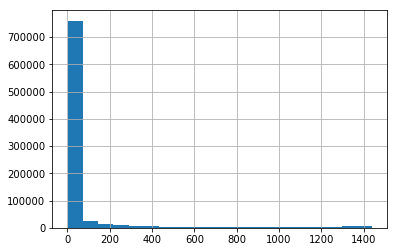

In [809]:
e.loc[(e.delta < 1440)&(e.delta>0)].delta.hist(bins = 20)

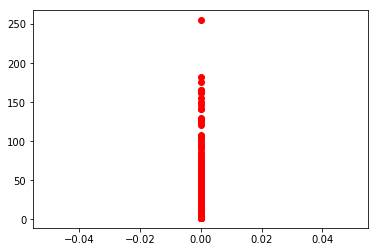

In [328]:
plt.plot(zero_dist['dist']['sum'], zero_dist['dist']['count'], 'ro')
plt.show()

In [329]:
387940 - zero_dist.shape[0]

107873

In [330]:
dist_ = item_cat.loc[(item_cat['dist']['count'] > 1)]

In [331]:
dist_.shape

(387940, 6)

In [369]:
dist_1 = item_cat.loc[(item_cat['dist']['sum'] >3)&(item_cat['dist']['count'] > 1)]

In [370]:
dist_1.shape

(81470, 10)

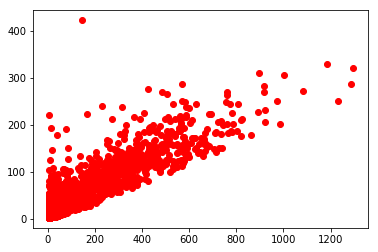

In [371]:
plt.plot(dist_1['dist']['sum'], dist_1['dist']['count'], 'ro')
plt.show()

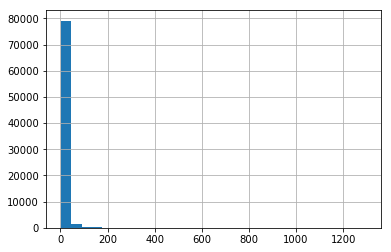

In [372]:
dist_1['dist']['sum'].hist(bins=30)

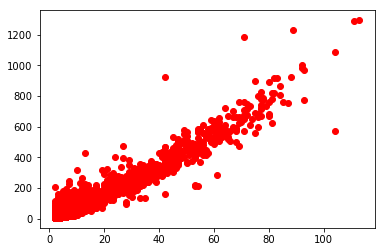

In [373]:
plt.plot( dist_1['cat']['nunique'],dist_1['dist']['sum'], 'ro')
plt.show()

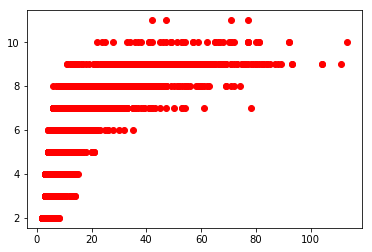

In [374]:
plt.plot(dist_1['cat']['nunique'],dist_1['dist']['nunique'], 'ro')
plt.show()

In [375]:
dist_1_ = dist_1.loc[dist_1['cat']['nunique']>20]

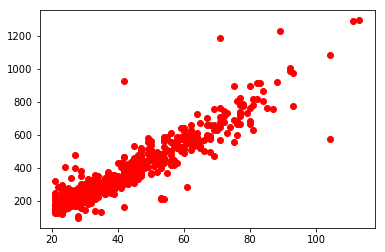

In [376]:
plt.plot( dist_1_['cat']['nunique'],dist_1_['dist']['sum'], 'ro')
plt.show()

In [377]:
dist_1__ = dist_1.loc[dist_1['cat']['nunique']<20]

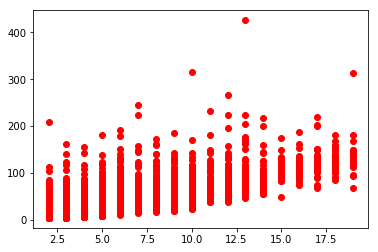

In [378]:
plt.plot( dist_1__['cat']['nunique'],dist_1__['dist']['sum'], 'ro')
plt.show()

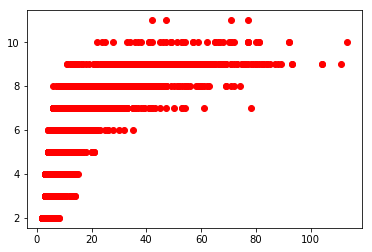

In [379]:
plt.plot(dist_1['cat']['nunique'],dist_1['dist']['nunique'], 'ro')
plt.show()

In [412]:
e_full_s = e.loc[e.ssid.isin(v_add_tran.index)]

In [410]:
v_add_tran.index

Index([ b'1000057_1',    b'1000093',  b'1000093_2',     b'100012',
           b'100020',  b'1000248_1', b'1000306_52',    b'1000454',
        b'1000593_1',    b'1000656',
       ...
           b'999047',      b'99915',     b'999295',     b'999378',
           b'999399',   b'999399_1',      b'99962',     b'999814',
           b'999869',     b'999926'],
      dtype='object', name='ssid', length=10758)

In [415]:
e_full_s.shape

(144196, 10)

In [419]:
sessions = e_full_s.ssid.unique()[:10]

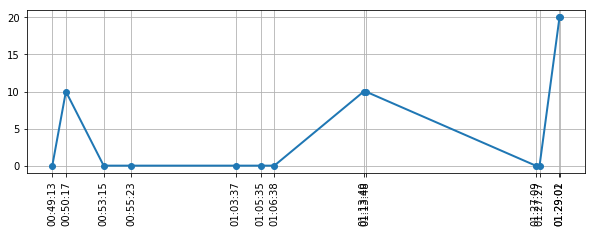

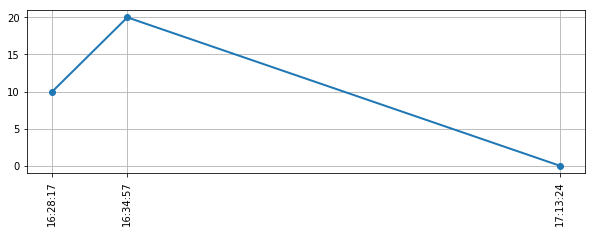

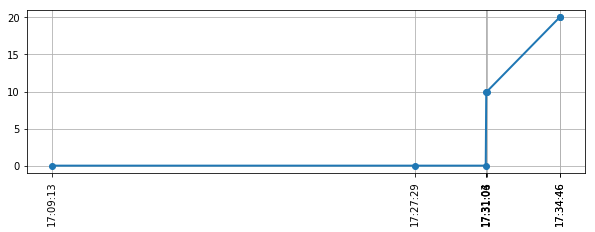

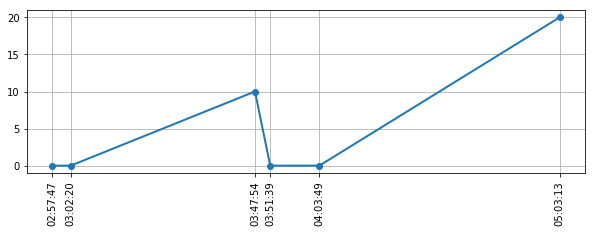

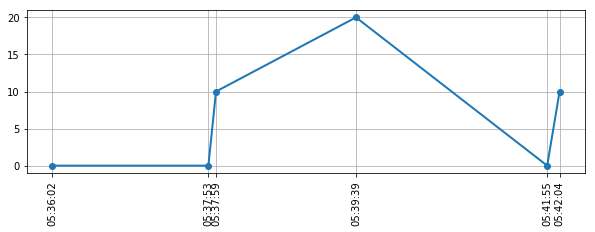

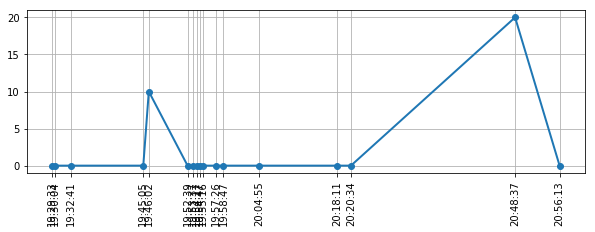

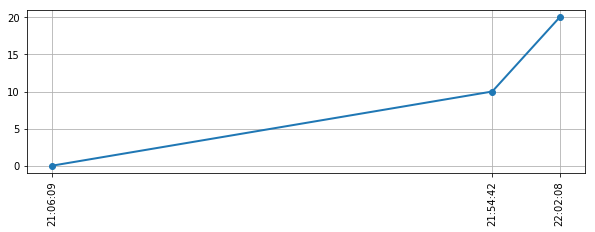

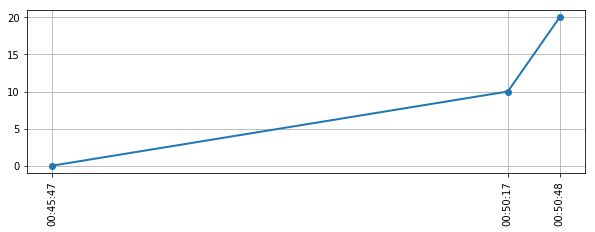

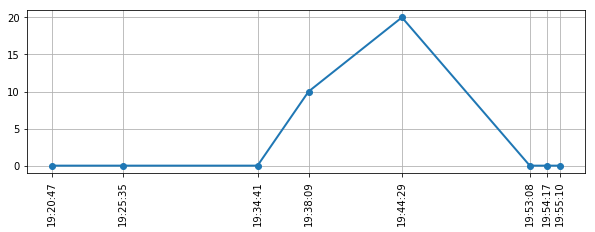

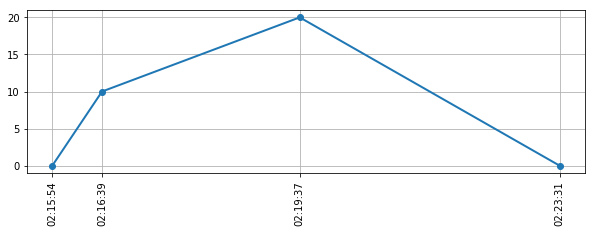

In [422]:
e_full_s['event'].replace('view', 0,inplace=True)
e_full_s['event'].replace('addtocart', 10,inplace=True)
e_full_s['event'].replace('transaction', 20,inplace=True)

import datetime

def t(time):
    return datetime.datetime.utcfromtimestamp(np.round(time/1000)).strftime('%H:%M:%S')

session = []
for i in sessions:
    session.append(e_full_s.loc[e_full_s.ssid == i])
for u in session:
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.grid(True)
    ax.plot((u.timestamp), u.event,'o-', linewidth=2)
    u['time'] = u.timestamp.apply(t)
    labels =   u['time'] 
    plt.xticks((u.timestamp), labels, rotation='vertical')
    
    
    
#     df.apply(f, axis=1)
plt.show()

In [259]:
e.loc[(e.itemid == 318909)&(e.visitorid == 1083495)].timestamp

1352572    1433043771835
Name: timestamp, dtype: int64

In [260]:
#свойств обьекта 49521 ближайщие к моменту взаимодествия с ним пользователя 102019
i_ = i.loc[i.timestamp <= min(e.loc[(e.itemid == 318909)&(e.visitorid == 1083495)].timestamp)]
i_.sort_values(by = 'timestamp').tail(10)

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [261]:
i['value'][i.property == 'categoryid'].values[0]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
category_tree.loc[category_tree.categoryid == 1022]

In [ ]:

category_tree.loc[category_tree.categoryid == 252]

In [ ]:
category_tree.loc[category_tree.categoryid == 872]

In [ ]:
category_tree.loc[category_tree.categoryid == 1600].iloc[0]['parentid']

In [ ]:
category_tree.categoryid[1600]

In [353]:
def get_cat(itemid, timestamp):
    i_ = item_properties.loc[(item_properties.itemid == itemid)&(item_properties.property =='categoryid')&(item_properties.timestamp <= timestamp)]
    i_.sort_values(by = 'timestamp')
    return int(a.iloc[0].value)

In [354]:
a = get_cat(318909,1433043771835)
a   

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
#количество items
item_properties.itemid.unique().shape

In [ ]:
# каждого items есть categoryid
item_properties.loc[item_properties.property == 'categoryid'].itemid.unique().shape

In [ ]:
# # каждого items есть categoryid
# item_properties.loc[item_properties.property == 'categoryid'].sort_values(by = 'itemid')
25


In [ ]:
l1 = get_cat_list(1022)
l2 = get_cat_list(252)

In [ ]:
cat1 = get_cat(item1,1)
cat2 = get_cat(item2,1)

In [183]:
def get_cat_list(categoryid):
    result = [categoryid]
    cat = categoryid
    while True:
        if cat == -1:
            break
        cat = category_tree.loc[category_tree.categoryid == cat].iloc[0]['parentid']
        result.append(cat)
    return result

def item_distance(cat1, cat2):
    #переписать на вычитание векторов и сумму не нулевых элементов
    cat_list1 = get_cat_list(cat1)
    cat_list2 = get_cat_list(cat2)
    cat_list1.reverse()
    cat_list2.reverse()
    #print(cat_list1, cat_list2)
    i = 0
    result = []
    while True:
        if (i >= len(cat_list1) or i >= len(cat_list2)):
            break
        result.append(cat_list1[i]-cat_list2[i])
        i = i +1
    r = 0
    #print(min(len(cat_list1),len(cat_list2)))
    for r_ in result:
        if r_ != 0:
            break
        r = r + 1
    return (len(cat_list1) - r + len(cat_list2)-r)
    

In [184]:
%%time
item_distance(1022,252)

CPU times: user 4.08 ms, sys: 335 µs, total: 4.42 ms
Wall time: 4.16 ms


1